# one element digital image correlation

- Affine deformation (not a Bilinear Quadrilateral (Q4), (Todo add the x*y)
- use non-linear Least Square from Scipy (Levenberg–Marquardt algorithm)
- use RectBivariateSpline for interpolation and gradient evaluation (from Scipy)

In [157]:
import skimage as sk
import numpy as np
import matplotlib.pylab as plt
from glob import glob
import os
from skimage import io

In [158]:
def get_number(string):
    '''Extract all digits from given string'''
    # https://stackoverflow.com/a/36434101/8069403
    return int(''.join(filter(str.isdigit, string)))

def load_from_dir(path, fileext='.tif'):
    image_pattern = os.path.join(path, '*'+fileext)
    image_list = sorted(glob(image_pattern),
                        key=get_number)
    
    print(len(image_list), 'images found:')
    print(', '.join(image_list[:2]) + '...,  ' +  image_list[-1])
    return [sk.io.imread(filename) for filename in image_list]

In [159]:
# load the images
path = "./images/"
images = load_from_dir(path, fileext='.png')

4 images found:
./images/Cam0181.png, ./images/Cam0182.png...,  ./images/Cam0184.png


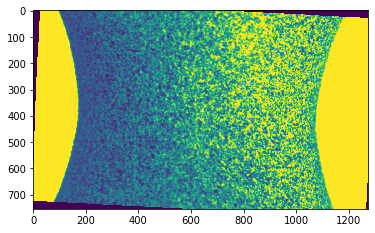

In [160]:
plt.imshow(images[1]);

https://scikit-image.org/docs/stable/api/api.html

In [161]:
from skimage.transform import pyramid_reduce
from scipy.interpolate import RectBivariateSpline
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html
from scipy.optimize import least_squares

In [162]:
# Select the two images
I, J = images[0], images[2]

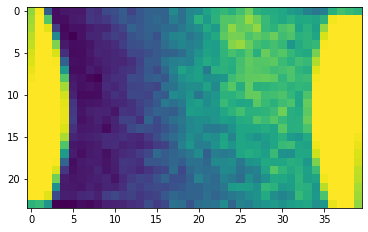

In [163]:
# test down scaling
downscale_factor = 16*2
I_coarse = pyramid_reduce(I, downscale_factor)

plt.imshow(I_coarse);

In [164]:
# affine transform
def affine_transform(x, y, p):
    u, v = p[0], p[1]
    e11, e12, e21, e22 = p[2:]
    x_def = u + e11*x + e12*y
    y_def = v + e21*x + e22*y
    return x_def, y_def

def transf_grad(x, y, p):
    one = np.ones_like(x)
    zero = np.zeros_like(x)
    Tx_dp = np.vstack([one, zero, x, y, zero, zero]).T
    Ty_dp = np.vstack([zero, one, zero, zero, x, y]).T
    return Tx_dp, Ty_dp

In [165]:
# the residuals:
def delta_xi(p, xi, yi, Ispline, Jspline):
    u, v = affine_transform(xi, yi, p)
    return Ispline(xi, yi, grid=False) - Jspline(u, v, grid=False)

# gradient of the residuals
def grad_xi(p, xi, yi, Ispline, Jspline):
    u, v = affine_transform(xi, yi, p)
    Tx, Ty = transf_grad(xi, yi, p)
    jac_x = -Tx*Jspline(u, v, dx=1, grid=False)[:, np.newaxis]
    jac_y = -Ty*Jspline(u, v, dy=1, grid=False)[:, np.newaxis]
    return jac_x + jac_y

In [166]:
def solve(I, J, box, downscale_factor, p_zero=[0, 0, 1, 0, 0, 1]):
    # Down sample the images
    if downscale_factor > 1:
        I_coarse = pyramid_reduce(I, downscale_factor)
        J_coarse = pyramid_reduce(J, downscale_factor)
    else:
        I_coarse = I
        J_coarse = J
        
    # Build spline interpolation
    xi = np.linspace(0, I.shape[0], I_coarse.shape[0])
    yi = np.linspace(0, I.shape[1], I_coarse.shape[1])

    Ispline = RectBivariateSpline(xi, yi, I_coarse)
    Jspline = RectBivariateSpline(xi, yi, J_coarse)

    # Place sample points
    x, y, w, h = box
    xi_span = np.linspace(x, x+w, w//downscale_factor)
    yi_span = np.linspace(y, y+h, h//downscale_factor)

    xi_grid, yi_grid = np.meshgrid(xi_span, yi_span)

    xi, yi = xi_grid.flatten(), yi_grid.flatten()
    
    # solve
    res = least_squares(delta_xi, p_zero,
                        jac=grad_xi,
                        args=(xi, yi, Ispline, Jspline))
    print(res.message)
    return res.x

In [167]:
# Define the element
box = 500, 300, 150, 160  # x, y, w, h
x, y, w, h = box
box_polyline = np.array([[x, x+w, x+w, x, x],
                         [y, y, y+h, y+h, y]]).T

In [168]:
# Loop over scales
p_opti = [0, 0, 1, 0, 0, 1]
for k in range(0, 6)[::-1]:
    downfactor = 2**k
    p_opti = solve(I, J, box, downfactor, p_zero=p_opti)

`ftol` termination condition is satisfied.
`ftol` termination condition is satisfied.
`ftol` termination condition is satisfied.
`ftol` termination condition is satisfied.
`ftol` termination condition is satisfied.
`xtol` termination condition is satisfied.


In [169]:
print(p_opti)

[ 1.20159363e+01  1.10086478e+01  1.00000000e+00 -1.37989740e-17
 -4.35427996e-17  1.00000000e+00]


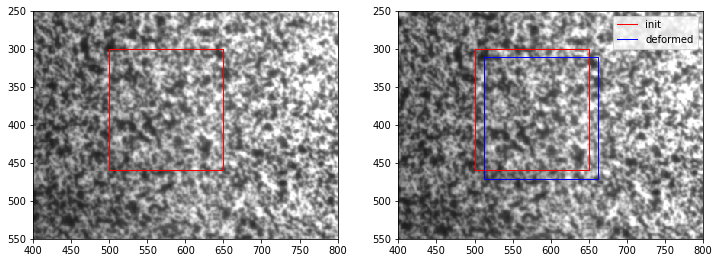

In [170]:
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(I, cmap = 'gray');
ax2.imshow(J, cmap = 'gray');
#ax1.set_title(image_list[k]);
#ax2.set_title(image_list[k+1]);
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='blue');
#ax1.plot(xi, yi, '.', color='red');

xDef, yDef = affine_transform(box_polyline[:, 0], box_polyline[:, 1], p_opti)
#ax2.plot(xDef, yDef, '.', color='red')
ax2.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='init');
ax2.plot(xDef, yDef,
         '-', color='blue', linewidth=1, label='deformed');
plt.legend();
ax1.set_xlim(400, 800);ax1.set_ylim(550, 250);
ax2.set_xlim(400, 800);ax2.set_ylim(550, 250);